In [ ]:
import json
import zipfile
import os

In [ ]:
!kaggle competitions download -c dogs-vs-cats

100%|███████████████████████████████████████▉| 812M/812M [01:57<00:00, 8.09MB/s]
100%|████████████████████████████████████████| 812M/812M [01:57<00:00, 7.27MB/s]


In [ ]:
zip_ref = zipfile.ZipFile('./dogs-vs-cats.zip', 'r')
zip_ref.extractall()
zip_ref.close()

In [ ]:
zip_ref = zipfile.ZipFile('./train.zip', 'r')
zip_ref.extractall('/home/mkhoa/Project/GCS/Cat-vs-Dog/Train')
zip_ref.close()

In [ ]:
zip_ref = zipfile.ZipFile('./test1.zip', 'r')
zip_ref.extractall('/home/mkhoa/Project/GCS/Cat-vs-Dog/Test')
zip_ref.close()

In [ ]:
import tensorflow as tf
import numpy as np
import datetime
import itertools
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import imgaug.augmenters as iaa
import PIL
import io

from pathlib import Path
from ipywidgets import FileUpload
from IPython.display import display
from tensorboard.plugins.hparams import api as hp

# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
tf.device('/GPU:0')

In [ ]:
train_dir = Path('/home/mkhoa/Project/GCS/Cat-vs-Dog/Train')
test_dir = Path('/home/mkhoa/Project/GCS/Cat-vs-Dog/Test')

In [ ]:
df_train = pd.DataFrame([x for x in train_dir.iterdir()], columns={'Path'})
df_train['Path'] = df_train['Path'].astype('str')
df_train['Label'] = df_train['Path'].str.split('/', expand=True)[7]
df_train['Label'] = df_train['Label'].apply(lambda x: 0 if 'cat' in x else 1)

In [ ]:
df_test = pd.DataFrame([x for x in test_dir.iterdir()], columns={'Path'})
df_test['Path'] = df_test['Path'].astype('str')

In [ ]:
df_train.groupby('Label').count()

,Path
Label,
0,12500
1,12500


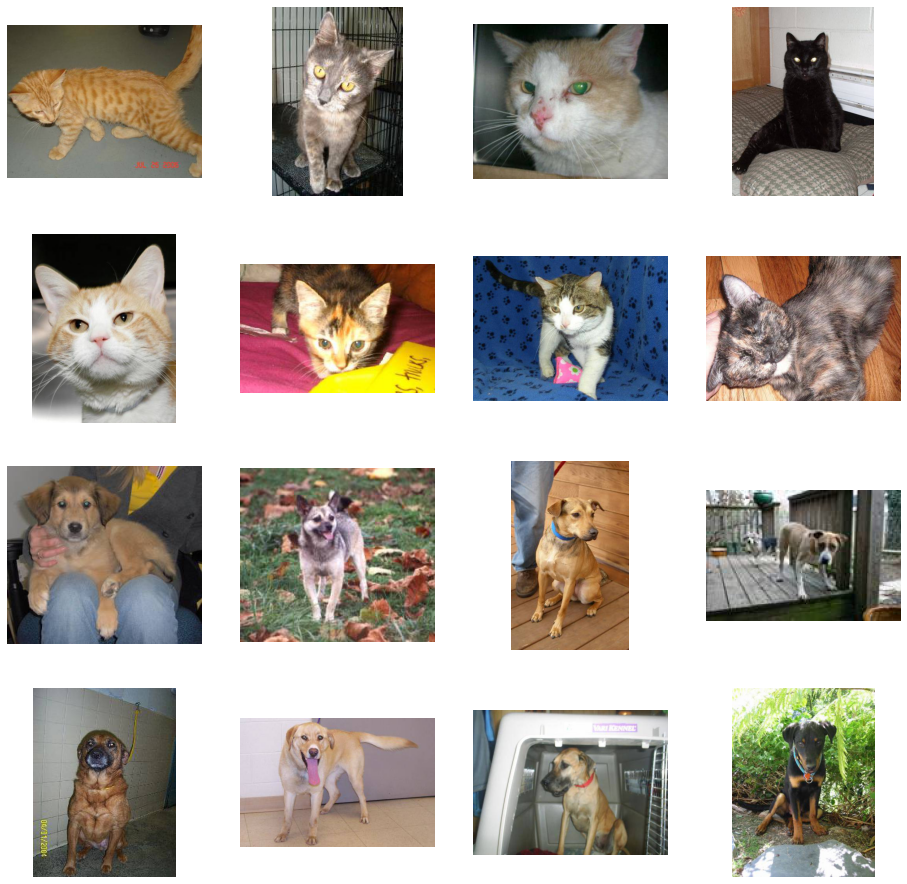

In [ ]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

next_cat_pix = list(df_train[df_train['Label'] == 0]['Path'].sample(8))
next_dog_pix = list(df_train[df_train['Label'] == 1]['Path'].sample(8))

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [ ]:
for i in df_train['Path'].sample(10):
    img_path = i
    img_raw = tf.io.read_file(img_path)
    img_tensor = tf.image.decode_jpeg(img_raw, channels=3)
    print(img_tensor.shape)

(405, 483, 3)
(341, 467, 3)
(319, 240, 3)
(307, 410, 3)
(307, 500, 3)
(500, 279, 3)
(375, 499, 3)
(499, 306, 3)
(375, 499, 3)
(377, 499, 3)


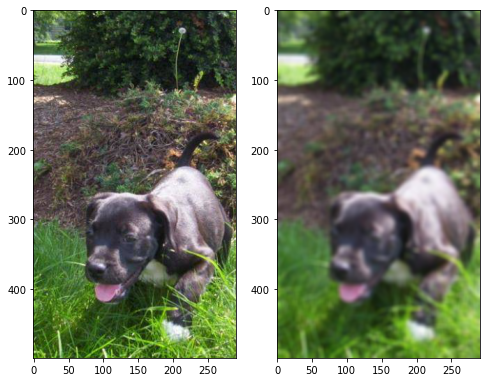

In [ ]:
# Image augmentation: Flip left to right and add blur
fig = plt.gcf()
fig.set_size_inches(8, 16)

for img_path in df_train['Path'].sample(1):
    img_raw = mpimg.imread(img_path)
    
    seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.GaussianBlur(sigma=(0, 8.0))
    ])
    
    img_aug = seq(image=img_raw)
    
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(1, 2, 1)
    plt.imshow(img_raw)
    
    sp = plt.subplot(1, 2, 2)
    plt.imshow(img_aug)

plt.show()

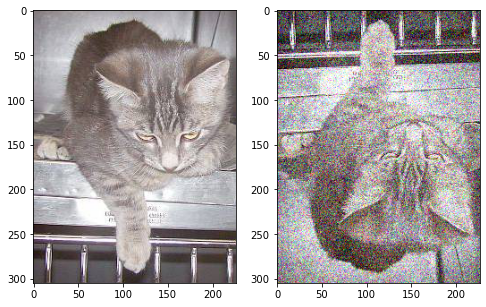

In [ ]:
# Image augmentation: Flip up side down and add noise to images
fig = plt.gcf()
fig.set_size_inches(8, 16)

for img_path in df_train['Path'].sample(1):
    img_raw = mpimg.imread(img_path)
    
    seq = iaa.Sequential([
    iaa.Flipud(1),
    iaa.imgcorruptlike.GaussianNoise(severity=3)
    ])
    
    img_aug = seq(image=img_raw)
    
    sp = plt.subplot(1, 2, 1)
    plt.imshow(img_raw)
    
    sp = plt.subplot(1, 2, 2)
    plt.imshow(img_aug)

plt.show()

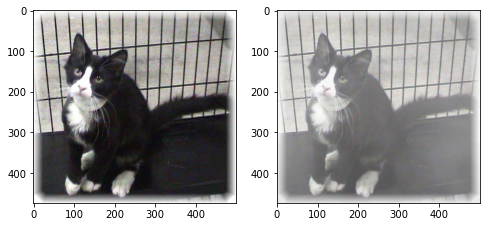

In [ ]:
# Image augmentation: Weather
fig = plt.gcf()
fig.set_size_inches(8, 16)

for img_path in df_train['Path'].sample(1):
    img_raw = mpimg.imread(img_path)
    
    seq = iaa.Sequential([
    iaa.Fog()
    ])
    
    img_aug = seq(image=img_raw)
    
    sp = plt.subplot(1, 2, 1)
    plt.imshow(img_raw)
    
    sp = plt.subplot(1, 2, 2)
    plt.imshow(img_aug)

plt.show()

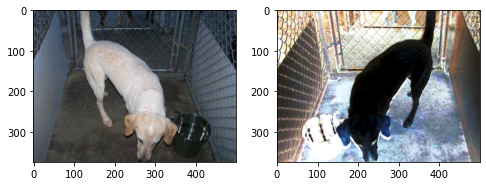

In [ ]:
# Image augmentation: Random augmentation
fig = plt.gcf()
fig.set_size_inches(8, 16)

for img_path in df_train['Path'].sample(1):
    img_raw = mpimg.imread(img_path)
    
    seq = iaa.Sequential([
    iaa.RandAugment(n=3, m=5)
    ])
    
    img_aug = seq(image=img_raw)
    
    sp = plt.subplot(1, 2, 1)
    plt.imshow(img_raw)
    
    sp = plt.subplot(1, 2, 2)
    plt.imshow(img_aug)

plt.show()

In [ ]:
# Split Train Set and Validation Set
# df_train_set = df_train.groupby('Label', as_index=False, group_keys=False).apply(lambda x: x.sample(n=11250))
df_train_set = df_train
df_validation_set = df_train.groupby('Label', as_index=False, group_keys=False).apply(lambda x: x.sample(n=2500))

In [ ]:
df_train_set.groupby('Label').count()

,Path
Label,
0,12500
1,12500


In [ ]:
df_validation_set.groupby('Label').count()

,Path
Label,
0,2500
1,2500


In [ ]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (224, 224), preserve_aspect_ratio=False)
    image = tf.cast(image, tf.float32)/255
    return image

def augment_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
        
    seq = iaa.Sequential([
    iaa.RandAugment(n=3, m=6)
    ])
    
    image = seq(image=img_raw)
    image = tf.image.resize(image, (224, 224), preserve_aspect_ratio=False)
    image = tf.cast(image, tf.float32)/255
    return image   
    
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

def load_and_aug_image(path):
    image = tf.io.read_file(path)
    return augment_image(image)

In [ ]:
# Load Dataset
ds_train = tf.data.Dataset.from_tensor_slices((df_train_set.Path.values, df_train_set.Label.values))
ds_valid = tf.data.Dataset.from_tensor_slices((df_validation_set.Path.values, df_validation_set.Label.values))

def load_and_preprocess_from_path_label(path, label):
  return load_and_preprocess_image(path), label

def load_and_aug_from_path_label(path, label):
  return load_and_aug_image(path), label

train_dataset = ds_train.map(load_and_preprocess_from_path_label)
train_aug_dataset = ds_train.map(load_and_aug_from_path_label)
test_dataset = ds_valid.map(load_and_preprocess_from_path_label)
test_aug_dataset = ds_valid.map(load_and_aug_from_path_label)

In [ ]:
train_dataset = train_dataset.concatenate(train_aug_dataset)
test_aug_dataset = test_dataset.concatenate(test_aug_dataset)

In [ ]:
# Mini-batch
BATCH_SIZE = 32

# add autotune means asking tensorflow to figure out the best settings for your VM/laptop running
AUTOTUNE = tf.data.experimental.AUTOTUNE
SHUFFLE_BUFFER_SIZE=50000

final_train_dataset = train_dataset.repeat().shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
final_test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
aug_test_dataset = test_aug_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False)
mobile_net.trainable=False  # freeze all the layers of the pre-trained model so their weights and bias won't be updated during gradient descent steps

In [ ]:
# nasnet = tf.keras.applications.NASNetLarge(input_shape=(224, 224, 3), include_top=False, weights=None, input_tensor=None, pooling=None)
# nasnet.trainable=False

In [ ]:
# vgg19 = tf.keras.applications.VGG19(include_top=False, weights="imagenet", input_tensor=None, input_shape=(224, 224, 3))
# vgg19.trainable=False

In [ ]:
with tf.device('/GPU:0'):
    model = tf.keras.models.Sequential([
        mobile_net,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               163968    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 2,432,321
Trainable params: 174,337
Non-trainable params: 2,257,984
________________________________________

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss='binary_crossentropy',
              metrics=["accuracy"])

In [ ]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=0,  # How often to log histogram visualizations
    embeddings_freq=0,  # How often to log embedding visualizations
    update_freq="epoch",
)  # How often to write logs (default: once per epoch)
print(log_dir)

logs/fit/20200914-044356


In [ ]:
steps_per_epoch=tf.math.ceil(2*len(df_train)/BATCH_SIZE).numpy()
history = model.fit(final_train_dataset,
                    validation_data=final_test_dataset, 
                    epochs=12, 
                    steps_per_epoch=steps_per_epoch,
                    callbacks=[tensorboard_callback]
                   )

Epoch 1/12
   1/1563 [..............................] - ETA: 1s - loss: 1.0400 - accuracy: 0.5000WARNING:tensorflow:From /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1563/1563 [==============================] - 71s 45ms/step - loss: 0.3366 - accuracy: 0.7775 - val_loss: 0.0440 - val_accuracy: 0.9868
Epoch 2/12
1563/1563 [==============================] - 75s 48ms/step - loss: 0.3509 - accuracy: 0.7563 - val_loss: 0.0393 - val_accuracy: 0.9860
Epoch 3/12
1563/1563 [==============================] - 66s 42ms/step - loss: 0.3598 - accuracy: 0.7490 - val_loss: 0.0313 - val_accuracy: 0.9880
Epoch 4/12
1563/1563 [==============================] - 69s 44ms/step - loss: 0.3629 - accuracy: 0.7451 - val_loss: 0.0390 - val_accuracy: 0.9842
Epoch 5/12
1563/1563 [==============================

In [ ]:
# Save the entire model to a HDF5 file
model.save('minh_khoa_mobile_net.h5')

In [ ]:
# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model('minh_khoa_mobile_net.h5')

In [ ]:
model.evaluate(aug_test_dataset)

313/313 [==============================] - 10s 32ms/step - loss: 0.3585 - accuracy: 0.7447


[0.35847118496894836, 0.744700014591217]

In [ ]:
model.evaluate(final_test_dataset)

157/157 [==============================] - 7s 44ms/step - loss: 0.0238 - accuracy: 0.9894


[0.023769496008753777, 0.9894000291824341]

In [ ]:
print(log_dir)

logs/fit/20200914-024400


In [ ]:
tensorboard --logdir=log_dir --port=8080 --bind_all

ERROR: Failed to launch TensorBoard (exited with 255).
Contents of stderr:
2020-09-14 02:59:27.971893: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
E0914 02:59:29.735472 140379809891712 program.py:312] TensorBoard could not bind to port 8080, it was already in use
ERROR: TensorBoard could not bind to port 8080, it was already in use

In [ ]:
uploader = FileUpload(accept='.jpg', multiple=False)
display(uploader)

FileUpload(value={}, accept='.jpg', description='Upload')

In [ ]:
image = uploader.data[0]
image = preprocess_image(image)
image = tf.reshape(image, [1,224,224,3])
prediction = model.predict(image)

for i in prediction:
    result = i

if i.astype(int) == 0:
    result_label = 'Cat'
elif i.astype(int) == 1:
    result_label = 'Dog'
else:
    result_label = 'Result'

print("The prediction is", result_label)

The prediction is Cat
